In [1]:
import os
import math
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import KATNetwork

In [2]:
num_in_channels = 2
num_out_channels = 1 
grid_size_train = 100
grid_size_test = 10

x_train = torch.linspace(-1, 1, grid_size_train, dtype=torch.float64)
y_train = torch.linspace(-1, 1, grid_size_train, dtype=torch.float64)

mesh_x_train, mesh_y_train = torch.meshgrid(x_train, y_train, indexing='ij')

in_train_data = torch.stack([mesh_x_train.flatten(), mesh_y_train.flatten()], dim=1)

x_test = torch.linspace(-1, 1, grid_size_test, dtype=torch.float64)
y_test = torch.linspace(-1, 1, grid_size_test, dtype=torch.float64)

mesh_x_test, mesh_y_test = torch.meshgrid(x_test, y_test, indexing='ij')

in_test_data = torch.stack([mesh_x_test.flatten(), mesh_y_test.flatten()], dim=1)

def compute_function(inputs):
    x = inputs[:, 0]
    y = inputs[:, 1]
    return torch.exp(torch.sin(math.pi * x) + y**2)

f_train = compute_function(in_train_data)
out_train_data = f_train.unsqueeze(1)

f_test = compute_function(in_test_data)
out_test_data = f_test.unsqueeze(1)

In [3]:
train_dataset = TensorDataset(in_train_data, out_train_data)
train_loader = DataLoader(train_dataset, batch_size=100000, shuffle=True)

test_dataset = TensorDataset(in_test_data, out_test_data)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device, "device")

Using cuda device


In [5]:
def rms_loss(pred, target):
    loss = (pred - target) ** 2
    return torch.sqrt(loss.mean())

def loss(pred, target, weights, sigmas, gamma=1e-5):
    loss = (pred - target) ** 2 

    reg = []
    for i in range(len(weights)):
        r = torch.abs(weights[i] / sigmas[i])
        reg.append(r.sum())

    return torch.sqrt(loss.mean()) + gamma * torch.stack(reg).sum()

In [6]:
model = KATNetwork.KATMLP(2, [1], 1, [(-1, 1), (-1, 1)], 20).to(device) 
optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,              
    max_iter=200,
    max_eval=200,       
    history_size=400,
    line_search_fn='strong_wolfe'
)

In [7]:
criterion = loss
num_epochs = 50

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
        model.train()

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets, 
                                [model.model[i].w for i in range(len(model.model))], 
                                [model.model[i].sigma for i in range(len(model.model))])

                loss.backward()

                return loss

            optimizer.step(closure)

        model.eval()
        train_loss = 0.0
        test_loss = 0.0

        with torch.no_grad():
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)

                loss = rms_loss(outputs, targets)

                train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)

                loss = rms_loss(outputs, targets)

                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.5e}, Test Loss: {test_loss:.5e}")

Epoch 1/50, Train Loss: 9.24494e-03, Test Loss: 1.06660e-02
Epoch 2/50, Train Loss: 1.00652e-03, Test Loss: 1.46078e-03
Epoch 3/50, Train Loss: 5.00205e-04, Test Loss: 7.49032e-04
Epoch 4/50, Train Loss: 3.17238e-04, Test Loss: 3.90817e-04
Epoch 5/50, Train Loss: 2.12945e-04, Test Loss: 3.39980e-04
Epoch 6/50, Train Loss: 2.11002e-04, Test Loss: 3.46200e-04
Epoch 7/50, Train Loss: 2.11018e-04, Test Loss: 3.46382e-04
Epoch 8/50, Train Loss: 2.11017e-04, Test Loss: 3.46382e-04
Epoch 9/50, Train Loss: 1.50080e-04, Test Loss: 2.22560e-04
Epoch 10/50, Train Loss: 6.20676e-05, Test Loss: 8.65650e-05
Epoch 11/50, Train Loss: 5.67097e-05, Test Loss: 8.80776e-05
Epoch 12/50, Train Loss: 5.67097e-05, Test Loss: 8.80776e-05
Epoch 13/50, Train Loss: 5.67097e-05, Test Loss: 8.80776e-05
Epoch 14/50, Train Loss: 5.67097e-05, Test Loss: 8.80776e-05
Epoch 15/50, Train Loss: 5.67097e-05, Test Loss: 8.80776e-05
Epoch 16/50, Train Loss: 5.67097e-05, Test Loss: 8.80776e-05
Epoch 17/50, Train Loss: 5.67097e

In [ ]:
print(train_loss_list)

In [ ]:
print(test_loss_list)

In [10]:
output_dir = '../func_model/'

model_save_path = os.path.join(output_dir, 'model_checkpoint.pth')

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

if os.path.exists(model_save_path):
    os.remove(model_save_path)
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)
print('Model saved')

Model saved


In [ ]:
model_save_path = '../func_model/model_checkpoint.pth'

if os.path.exists(model_save_path):
    checkpoint = torch.load(model_save_path, weights_only=True, map_location=device)
    if 'model_state_dict' in checkpoint and 'optimizer_state_dict' in checkpoint and 'epoch' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'Loaded checkpoint from epoch {checkpoint['epoch'] + 1}')
    else:
        print('Checkpoint file is missing some keys, starting from scratch.')

Loaded checkpoint from epoch 500


In [11]:
xlist = np.linspace(-2, 2, 1000).tolist()

ylist = [model.model[0].eval_func(x, 0, 0) for x in xlist]

In [20]:
model.model[1].mx_start

tensor([[[[-1.0000, -0.8947, -0.7895, -0.6842, -0.5789, -0.4737, -0.3684,
           -0.2632, -0.1579, -0.0526,  0.0526,  0.1579,  0.2632,  0.3684,
            0.4737,  0.5789,  0.6842,  0.7895,  0.8947,  1.0000]]]],
       device='cuda:0')

In [21]:
model.model[1].mx_train

Parameter containing:
tensor([[0.5865]], device='cuda:0', requires_grad=True)

In [22]:
model.model[1].sigma

Parameter containing:
tensor([[[0.4483, 0.0445, 0.1736, 0.2875, 0.2862, 0.2650, 0.0636, 0.1970,
          0.1188, 0.7767, 0.2730, 0.0376, 0.0452, 0.0451, 0.0451, 0.0451,
          0.0451, 0.0451, 0.0451, 0.0451]]], device='cuda:0',
       requires_grad=True)

In [23]:
model.model[1].w

Parameter containing:
tensor([[[ 1.1517e-01, -6.0618e-05,  3.2719e-03, -5.8270e-02, -3.2247e-02,
          -1.8249e-01,  4.3934e-04,  1.6500e-01, -1.0907e-01,  6.1227e+00,
           6.6382e+00,  8.3243e-03,  4.8338e-03, -4.1477e-03,  4.2242e-03,
          -4.0607e-03, -4.4985e-03,  2.7205e-03,  4.6380e-03,  4.1912e-03]]],
       device='cuda:0', requires_grad=True)

In [24]:
model.model[1].alpha

Parameter containing:
tensor([[[-4.9827e-02,  4.5072e-05,  4.6647e-04, -7.0158e-04,  3.0604e-02,
          -4.2850e-03,  2.8139e-03, -1.2616e-03, -1.1658e-03,  5.5631e-01,
          -2.3102e-01,  1.6807e-05, -9.9249e-07,  3.6360e-12, -3.9724e-26,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]],
       device='cuda:0', requires_grad=True)

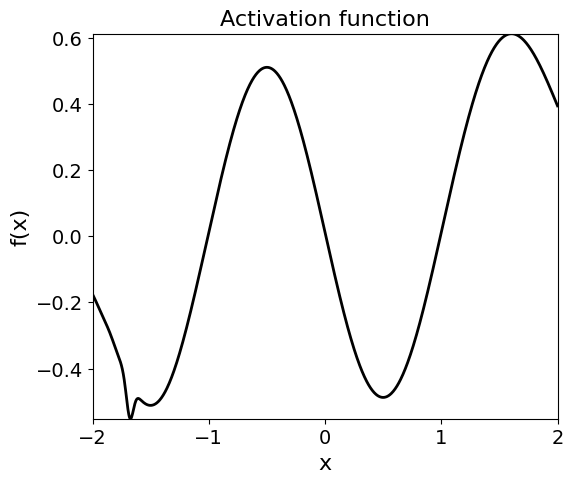

In [12]:
plt.figure(figsize=(6, 5))
plt.plot(xlist, ylist, color='black', linestyle='-', linewidth=2)
plt.xlabel("x", fontsize=16)
plt.ylabel("f(x)", fontsize=16)
plt.title("Activation function", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-2, 2)
plt.ylim(min(ylist), max(ylist))
plt.show()

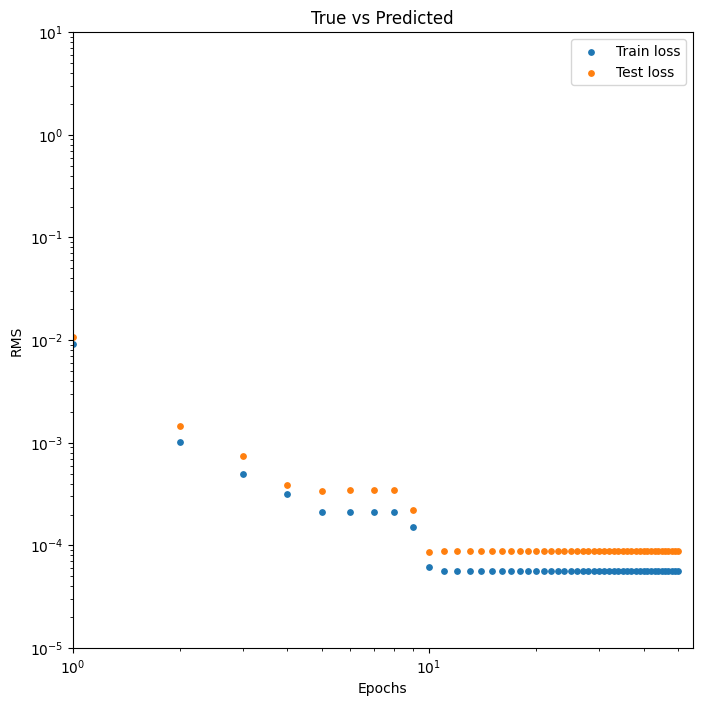

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter([i for i in range(1, len(train_loss_list)+1)], train_loss_list, label='Train loss', s=15, alpha=1)
plt.scatter([i for i in range(1, len(train_loss_list)+1)], test_loss_list, label='Test loss', s=15, alpha=1)
plt.xlabel("Epochs")
plt.ylabel("RMS")
plt.title("True vs Predicted")
plt.xlim(1, 1.1 * len(train_loss_list))
plt.ylim(1e-5, 10)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()